# Moving Horizon Estimation

Richard M. Murray, 24 Feb 2023

In this notebook we illustrate the implementation of moving horizon estimation (MHE)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import control as ct

import control.optimal as opt
import control.flatsys as fs

## System Description

The dynamics of the system
with disturbances on the $x$ and $y$ variables is given by

$$
  \begin{aligned}
    m \ddot x &= F_1 \cos\theta - F_2 \sin\theta - c \dot x + d_x, \\
    m \ddot y &= F_1 \sin\theta + F_2 \cos\theta - c \dot y - m g + d_y, \\
    J \ddot \theta &= r F_1.
  \end{aligned}
$$

The measured values of the system are the position and orientation,
with added noise $n_x$, $n_y$, and $n_\theta$:

$$
  \vec y = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} + 
  \begin{bmatrix} n_x \\ n_y \\ n_z \end{bmatrix}.
$$

In [2]:
# pvtol = nominal system (no disturbances or noise)
# noisy_pvtol = pvtol w/ process disturbances and sensor noise
from pvtol import pvtol, pvtol_noisy, plot_results
import pvtol as pvt

# Find the equiblirum point corresponding to the origin
xe, ue = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), [0, 0, 0, 0, 0, 0],
    iu=range(2, pvtol.ninputs), iy=[0, 1])

# Initial condition = 2 meters right, 1 meter up
x0, u0 = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), np.array([2, 1, 0, 0, 0, 0]),
    iu=range(2, pvtol.ninputs), iy=[0, 1])

# Extract the linearization for use in LQR design
pvtol_lin = pvtol.linearize(xe, ue)
A, B = pvtol_lin.A, pvtol_lin.B

print(pvtol, "\n")
print(pvtol_noisy)

<FlatSystem>: pvtol
Inputs (2): ['F1', 'F2']
Outputs (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

Update: <function _pvtol_update at 0x113697ac0>
Output: <function _pvtol_output at 0x113697a30>

Forward: <function _pvtol_flat_forward at 0x167b2fd00>
Reverse: <function _pvtol_flat_reverse at 0x167b2fbe0> 

<NonlinearIOSystem>: pvtol_noisy
Inputs (7): ['F1', 'F2', 'Dx', 'Dy', 'Nx', 'Ny', 'Nth']
Outputs (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

Update: <function _noisy_update at 0x167b2fc70>
Output: <function _noisy_output at 0x167b2ff40>


### Control Design

In [3]:
#
# LQR design w/ physically motivated weighting
#
# Shoot for 10 cm error in x, 10 cm error in y.  Try to keep the angle
# less than 5 degrees in making the adjustments.  Penalize side forces
# due to loss in efficiency.
#

Qx = np.diag([100, 10, (180/np.pi) / 5, 0, 0, 0])
Qu = np.diag([10, 1])
K, _, _ = ct.lqr(A, B, Qx, Qu)

# Compute the full state feedback solution
lqr_ctrl, _ = ct.create_statefbk_iosystem(pvtol, K)

# Define the closed loop system that will be used to generate trajectories
lqr_clsys = ct.interconnect(
    [pvtol_noisy, lqr_ctrl],
    inplist = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    inputs = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    outlist = pvtol.output_labels + lqr_ctrl.output_labels,
    outputs = pvtol.output_labels + lqr_ctrl.output_labels
)
print(lqr_clsys)

<InterconnectedSystem>: sys[4]
Inputs (13): ['xd[0]', 'xd[1]', 'xd[2]', 'xd[3]', 'xd[4]', 'xd[5]', 'ud[0]', 'ud[1]', 'Dx', 'Dy', 'Nx', 'Ny', 'Nth']
Outputs (8): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'F1', 'F2']
States (6): ['pvtol_noisy_x0', 'pvtol_noisy_x1', 'pvtol_noisy_x2', 'pvtol_noisy_x3', 'pvtol_noisy_x4', 'pvtol_noisy_x5']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x167b58dc0>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x167b58e50>


/Users/murray/src/python-control/murrayrm/control/statefbk.py:783: UserWarning: cannot verify system output is system state
  warnings.warn("cannot verify system output is system state")


In [4]:
# Disturbance and noise intensities
Qv = np.diag([1e-2, 1e-2])
Qw = np.array([[1e-4, 0, 1e-5], [0, 1e-4, 1e-5], [1e-5, 1e-5, 1e-4]])

# Initial state covariance
P0 = np.eye(pvtol.nstates)

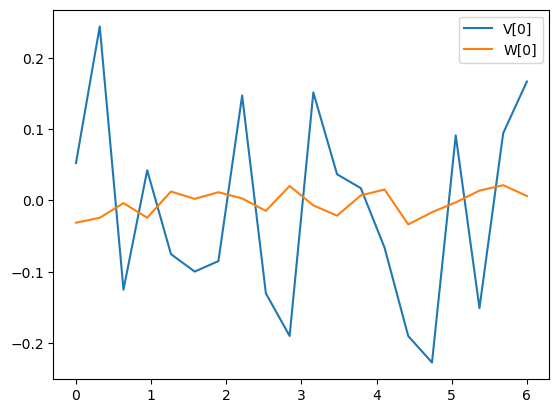

In [5]:
# Create the time vector for the simulation
Tf = 6
timepts = np.linspace(0, Tf, 20)

# Create representative process disturbance and sensor noise vectors
# np.random.seed(117)           # avoid figures changing from run to run
V = ct.white_noise(timepts, Qv)
# V = np.clip(V0, -0.1, 0.1)    # Hold for later
W = ct.white_noise(timepts, Qw)
# plt.plot(timepts, V0[0], 'b--', label="V[0]")
plt.plot(timepts, V[0], label="V[0]")
plt.plot(timepts, W[0], label="W[0]")
plt.legend();

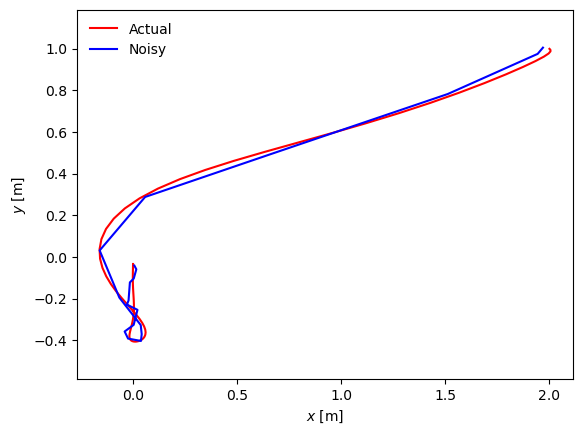

<Figure size 640x480 with 0 Axes>

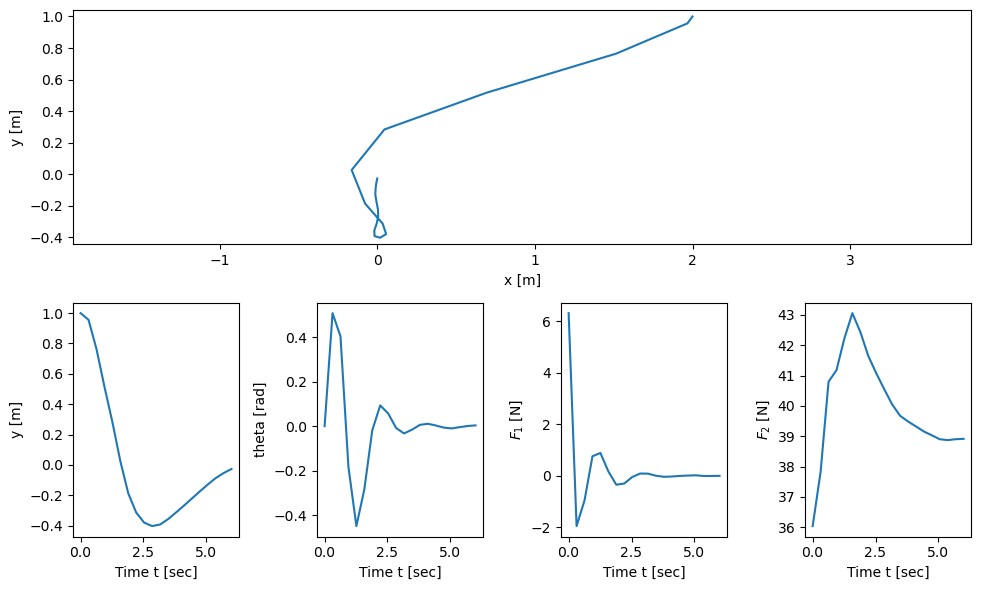

In [6]:
# Desired trajectory
xd, ud = xe, ue
# xd = np.vstack([
#     np.sin(2 * np.pi * timepts / timepts[-1]), 
#     np.zeros((5, timepts.size))])
# ud = np.outer(ue, np.ones_like(timepts))

# Run a simulation with full state feedback (no noise) to generate a trajectory
uvec = [xd, ud, V, W*0]
lqr_resp = ct.input_output_response(lqr_clsys, timepts, uvec, x0)
U = lqr_resp.outputs[6:8]                    # controller input signals
Y = lqr_resp.outputs[0:3] + W                # noisy output signals (noise in pvtol_noisy)

# Compare to the no noise case
uvec = [xd, ud, V*0, W*0]
lqr0_resp = ct.input_output_response(lqr_clsys, timepts, uvec, x0)
lqr0_fine = ct.input_output_response(lqr_clsys, timepts, uvec, x0, 
                                     t_eval=np.linspace(timepts[0], timepts[-1], 100))
U0 = lqr0_resp.outputs[6:8]
Y0 = lqr0_resp.outputs[0:3]

# Compare the results
# plt.plot(Y0[0], Y0[1], 'k--', linewidth=2, label="No disturbances")
plt.plot(lqr0_fine.states[0], lqr0_fine.states[1], 'r-', label="Actual")
plt.plot(Y[0], Y[1], 'b-', label="Noisy")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.axis('equal')
plt.legend(frameon=False)

plt.figure()
plot_results(timepts, lqr_resp.states, lqr_resp.outputs[6:8]);

In [7]:
# Utility functions for making plots
def plot_state_comparison(
    timepts, est_states, act_states=None, estimated_label='$\\hat x_{i}$', actual_label='$x_{i}$',
    start=0):
    for i in range(sys.nstates):
        plt.subplot(2, 3, i+1)
        if act_states is not None:
            plt.plot(timepts[start:], act_states[i, start:], 'r--', 
                     label=actual_label.format(i=i))
        plt.plot(timepts[start:], est_states[i, start:], 'b', 
                 label=estimated_label.format(i=i))
        plt.legend()
    plt.tight_layout()
        
# Define a function to plot out all of the relevant signals
def plot_estimator_response(timepts, estimated, U, V, Y, W, start=0):
    # Plot the input signal and disturbance
    for i in [0, 1]:
        # Input signal (the same across all)
        plt.subplot(4, 3, i+1)
        plt.plot(timepts[start:], U[i, start:], 'k')
        plt.ylabel(f'U[{i}]')

        # Plot the estimated disturbance signal
        plt.subplot(4, 3, 4+i)
        plt.plot(timepts[start:], estimated.inputs[i, start:], 'b-', label="est")
        plt.plot(timepts[start:], V[i, start:], 'k', label="actual")
        plt.ylabel(f'V[{i}]')

    plt.subplot(4, 3, 6)
    plt.plot(0, 0, 'b', label="estimated")
    plt.plot(0, 0, 'k', label="actual")
    plt.plot(0, 0, 'r', label="measured")
    plt.legend(frameon=False)
    plt.grid(False)
    plt.axis('off')
    
    # Plot the output (measured and estimated)   
    for i in [0, 1, 2]:
        plt.subplot(4, 3, 7+i)
        plt.plot(timepts[start:], Y[i, start:], 'r', label="measured")
        plt.plot(timepts[start:], estimated.states[i, start:], 'b', label="measured")
        plt.plot(timepts[start:], Y[i, start:] - W[i, start:], 'k', label="actual")
        plt.ylabel(f'Y[{i}]')
    
    for i in [0, 1, 2]:
        plt.subplot(4, 3, 10+i)
        plt.plot(timepts[start:], estimated.outputs[i, start:], 'b', label="estimated")
        plt.plot(timepts[start:], W[i, start:], 'k', label="actual")
        plt.ylabel(f'W[{i}]')
        plt.xlabel('Time [s]')

    plt.tight_layout()

## State Estimation

In [8]:
# Create a new system with only x, y, theta as outputs
# TODO: add this to pvtol.py?
sys = ct.NonlinearIOSystem(
    pvt._noisy_update, lambda t, x, u, params: x[0:3], name="pvtol_noisy",
    states = [f'x{i}' for i in range(6)],
    inputs = ['F1', 'F2'] + ['Dx', 'Dy'],
    outputs = ['x', 'y', 'theta']
)

<NonlinearIOSystem>: sys[7]
Inputs (5): ['y[0]', 'y[1]', 'y[2]', 'F1', 'F2']
Outputs (6): ['xhat[0]', 'xhat[1]', 'xhat[2]', 'xhat[3]', 'xhat[4]', 'xhat[5]']
States (42): ['xhat[0]', 'xhat[1]', 'xhat[2]', 'xhat[3]', 'xhat[4]', 'xhat[5]', 'P[0,0]', 'P[0,1]', 'P[0,2]', 'P[0,3]', 'P[0,4]', 'P[0,5]', 'P[1,0]', 'P[1,1]', 'P[1,2]', 'P[1,3]', 'P[1,4]', 'P[1,5]', 'P[2,0]', 'P[2,1]', 'P[2,2]', 'P[2,3]', 'P[2,4]', 'P[2,5]', 'P[3,0]', 'P[3,1]', 'P[3,2]', 'P[3,3]', 'P[3,4]', 'P[3,5]', 'P[4,0]', 'P[4,1]', 'P[4,2]', 'P[4,3]', 'P[4,4]', 'P[4,5]', 'P[5,0]', 'P[5,1]', 'P[5,2]', 'P[5,3]', 'P[5,4]', 'P[5,5]']

Update: <function create_estimator_iosystem.<locals>._estim_update at 0x1685997e0>
Output: <function create_estimator_iosystem.<locals>._estim_output at 0x16859a4d0>
xe=array([ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
       -1.766654e-27,  0.000000e+00]), P0=array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0

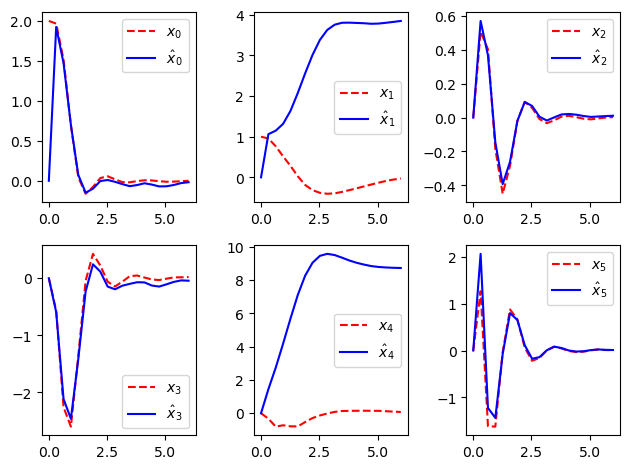

In [9]:
# Standard Kalman filter
linsys = sys.linearize(xe, [ue, V[:, 0] * 0])
# print(linsys)
B = linsys.B[:, 0:2]
G = linsys.B[:, 2:4]
linsys = ct.ss(
    linsys.A, B, linsys.C, 0,
    states=sys.state_labels, inputs=sys.input_labels[0:2], outputs=sys.output_labels)
# print(linsys)

estim = ct.create_estimator_iosystem(linsys, Qv, Qw, G=G, P0=P0)
print(estim)
print(f'{xe=}, {P0=}')

kf_resp = ct.input_output_response(
    estim, timepts, [Y, U], X0 = [xe, P0.reshape(-1)])
plot_state_comparison(timepts, kf_resp.outputs, lqr_resp.states)

### Extended Kalman filter

In [10]:
# Define the disturbance input and measured output matrices
F = np.array([[0, 0], [0, 0], [0, 0], [1/pvtol.params['m'], 0], [0, 1/pvtol.params['m']], [0, 0]])
C = np.eye(3, 6)

Qwinv = np.linalg.inv(Qw)

# Estimator update law
def estimator_update(t, x, u, params):
    # Extract the states of the estimator
    xhat = x[0:pvtol.nstates]
    P = x[pvtol.nstates:].reshape(pvtol.nstates, pvtol.nstates)

    # Extract the inputs to the estimator
    y = u[0:3]                  # just grab the first three outputs
    u = u[6:8]                  # get the inputs that were applied as well

    # Compute the linearization at the current state
    A = pvtol.A(xhat, u)        # A matrix depends on current state
    # A = pvtol.A(xe, ue)       # Fixed A matrix (for testing/comparison)
    
    # Compute the optimal "gain
    L = P @ C.T @ Qwinv

    # Update the state estimate
    xhatdot = pvtol.updfcn(t, xhat, u, params) - L @ (C @ xhat - y)

    # Update the covariance
    Pdot = A @ P + P @ A.T - P @ C.T @ Qwinv @ C @ P + F @ Qv @ F.T

    # Return the derivative
    return np.hstack([xhatdot, Pdot.reshape(-1)])

def estimator_output(t, x, u, params):
    # Return the estimator states
    return x[0:pvtol.nstates]

ekf = ct.NonlinearIOSystem(
    estimator_update, estimator_output,
    states=pvtol.nstates + pvtol.nstates**2,
    inputs= pvtol_noisy.output_labels \
        + pvtol_noisy.input_labels[0:pvtol.ninputs],
    outputs=[f'xh{i}' for i in range(pvtol.nstates)]
)
print(ekf)

<NonlinearIOSystem>: sys[8]
Inputs (8): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'F1', 'F2']
Outputs (6): ['xh0', 'xh1', 'xh2', 'xh3', 'xh4', 'xh5']
States (42): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]', 'x[9]', 'x[10]', 'x[11]', 'x[12]', 'x[13]', 'x[14]', 'x[15]', 'x[16]', 'x[17]', 'x[18]', 'x[19]', 'x[20]', 'x[21]', 'x[22]', 'x[23]', 'x[24]', 'x[25]', 'x[26]', 'x[27]', 'x[28]', 'x[29]', 'x[30]', 'x[31]', 'x[32]', 'x[33]', 'x[34]', 'x[35]', 'x[36]', 'x[37]', 'x[38]', 'x[39]', 'x[40]', 'x[41]']

Update: <function estimator_update at 0x1685100d0>
Output: <function estimator_output at 0x168512170>


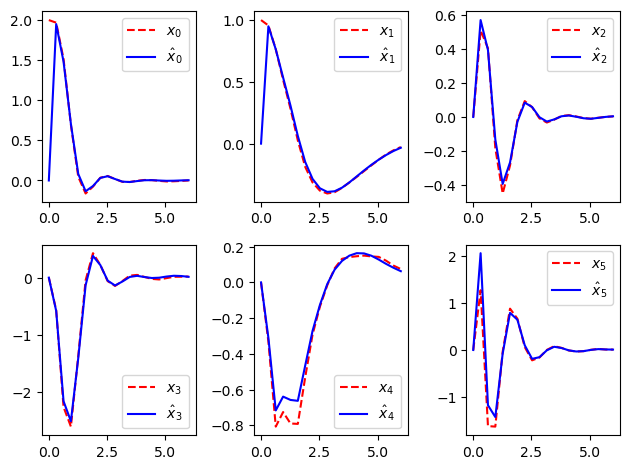

In [11]:
ekf_resp = ct.input_output_response(
    ekf, timepts, [lqr_resp.states, lqr_resp.outputs[6:8]],
    X0=[xe, P0.reshape(-1)])
plot_state_comparison(timepts, ekf_resp.outputs, lqr_resp.states)

Summary statistics:
* Cost function calls: 5051
* Final cost: 354.3319137685172


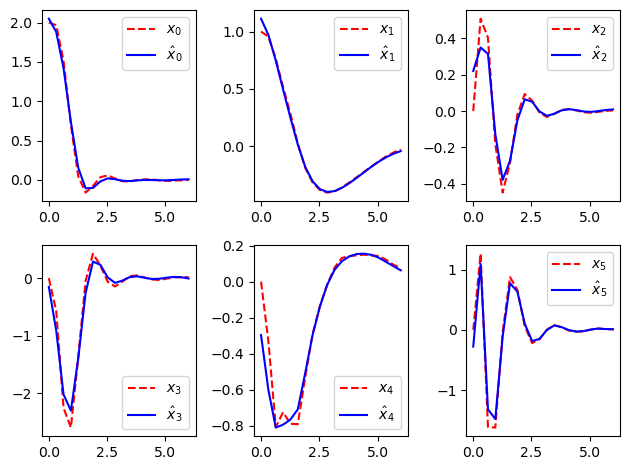

In [12]:
# Define the optimal estimation problem
traj_cost = opt.gaussian_likelihood_cost(sys, Qv, Qw)
init_cost = lambda xhat, x: (xhat - x) @ P0 @ (xhat - x)
oep = opt.OptimalEstimationProblem(
        sys, timepts, traj_cost, terminal_cost=init_cost)

# Compute the estimate from the noisy signals
est = oep.compute_estimate(Y, U, X0=lqr_resp.states[:, 0])
plot_state_comparison(timepts, est.states, lqr_resp.states)

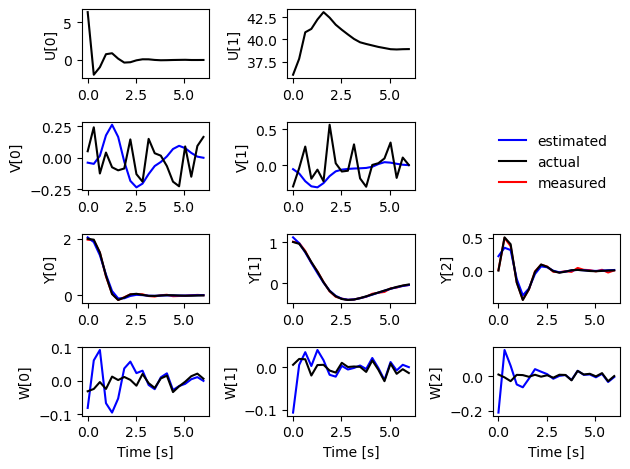

In [13]:
# Plot the response of the estimator
plot_estimator_response(timepts, est, U, V, Y, W)

Summary statistics:
* Cost function calls: 9464
* Final cost: 212754409.97292745


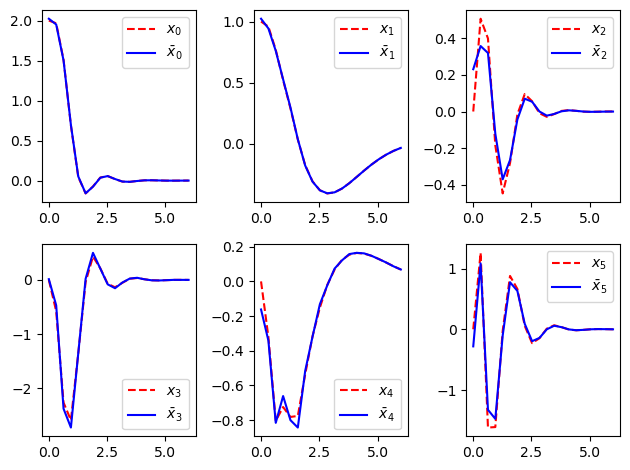

In [14]:
# Noise free and disturbance free => estimation should be near perfect
noisefree_cost = opt.gaussian_likelihood_cost(sys, Qv, Qw*1e-6)
oep0 = opt.OptimalEstimationProblem(
        sys, timepts, noisefree_cost, terminal_cost=init_cost)
est0 = oep0.compute_estimate(Y0, U0, X0=lqr0_resp.states[:, 0],
                            initial_guess=(lqr0_resp.states, V * 0))
plot_state_comparison(
    timepts, est0.states, lqr0_resp.states, estimated_label='$\\bar x_{i}$')

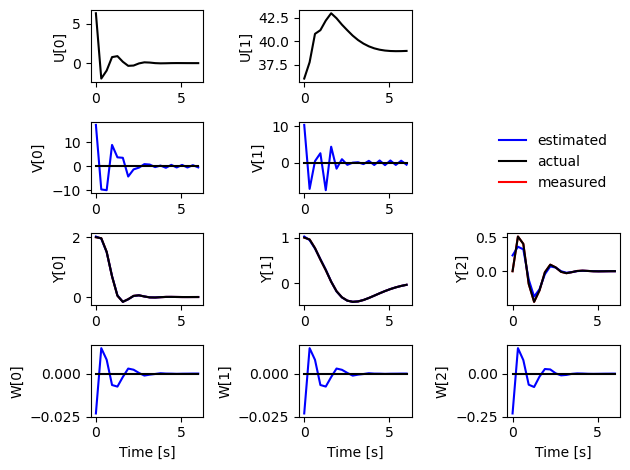

In [15]:
plot_estimator_response(timepts, est0, U0, V*0, Y0, W*0)

### Bounded disturbances

Another thing that the MHE can handled is input distributions that are bounded.  We implement that here by carrying out the optimal estimation problem with constraints.

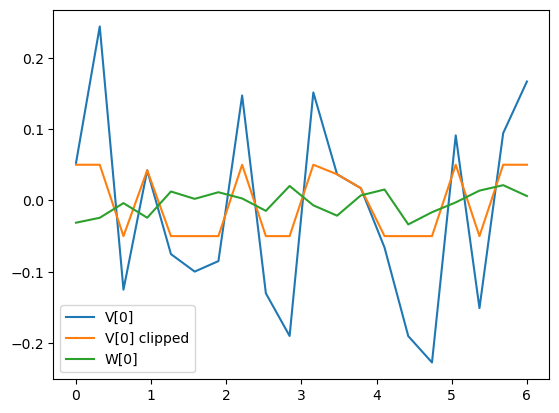

In [16]:
V_clipped = np.clip(V, -0.05, 0.05)    

plt.plot(timepts, V[0], label="V[0]")
plt.plot(timepts, V_clipped[0], label="V[0] clipped")
plt.plot(timepts, W[0], label="W[0]")
plt.legend();

Summary statistics:
* Cost function calls: 3572
* Constraint calls: 3756
* Final cost: 531.7451775567271


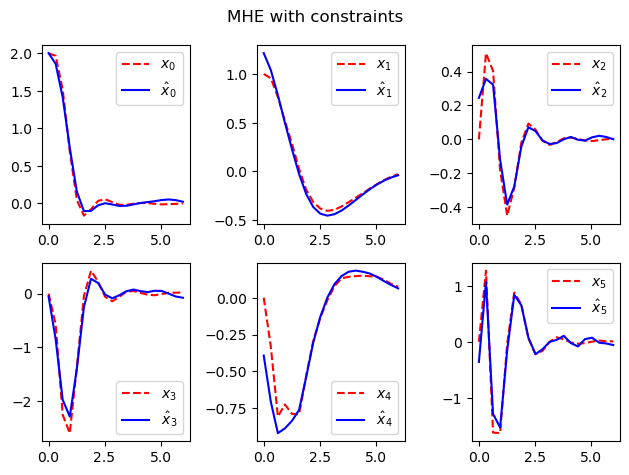

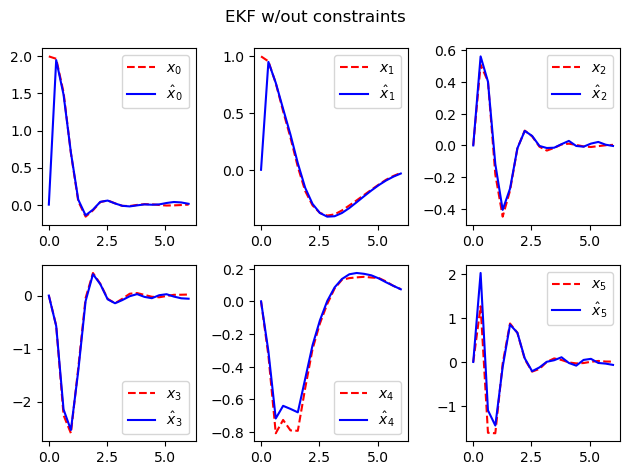

In [17]:
uvec = [xe, ue, V_clipped, W]
clipped_resp = ct.input_output_response(lqr_clsys, timepts, uvec, x0)
U_clipped = clipped_resp.outputs[6:8]        # controller input signals
Y_clipped = clipped_resp.outputs[0:3] + W    # noisy output signals

traj_constraint = opt.disturbance_range_constraint(
    sys, [-0.05, -0.05], [0.05, 0.05])
oep_clipped = opt.OptimalEstimationProblem(
        sys, timepts, traj_cost, terminal_cost=init_cost,
        trajectory_constraints=traj_constraint)

est_clipped = oep_clipped.compute_estimate(
    Y_clipped, U_clipped, X0=lqr0_resp.states[:, 0])
plot_state_comparison(timepts, est_clipped.states, lqr_resp.states)
plt.suptitle("MHE with constraints")
plt.tight_layout()

plt.figure()
ekf_unclipped = ct.input_output_response(
    ekf, timepts, [clipped_resp.states, clipped_resp.outputs[6:8]],
    X0=[xe, P0.reshape(-1)])

plot_state_comparison(timepts, ekf_unclipped.outputs, lqr_resp.states)
plt.suptitle("EKF w/out constraints")
plt.tight_layout()

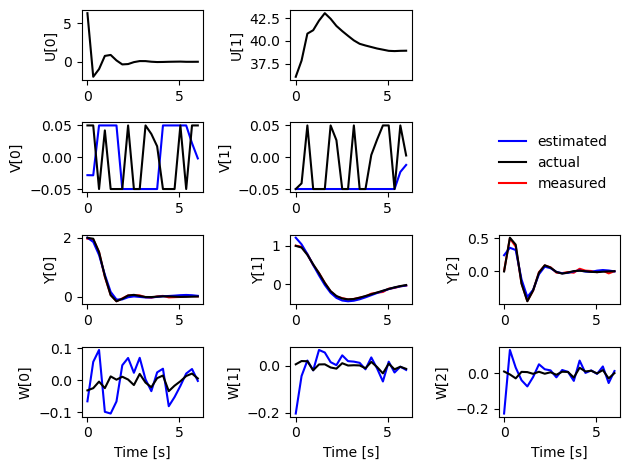

In [18]:
plot_estimator_response(timepts, est_clipped, U, V_clipped, Y, W)

## Moving Horizon Estimation (MHE)

We can now move to implementation of a moving horizon estimator, using our fixed horizon optimal estimator.

In [19]:
# Use a shorter horizon
mhe_timepts = timepts[0:5]
oep = opt.OptimalEstimationProblem(
        sys, mhe_timepts, traj_cost, terminal_cost=init_cost)

try:
    mhe = oep.create_mhe_iosystem(2)
    
    est_mhe = ct.input_output_response(
        mhe, timepts, [Y, U], X0=resp.states[:, 0], 
        params={'verbose': True}
    )
    plot_state_comparison(timepts, est_mhe.states, lqr_resp.states)
except:
    print("MHE for continuous-time systems not implemented")

MHE for continuous-time systems not implemented


In [20]:
# Create discrete-time version of PVTOL
Ts = 0.1
print(f"Sample time: {Ts=}")
dsys = ct.NonlinearIOSystem(
    lambda t, x, u, params: x + Ts * sys.updfcn(t, x, u, params),
    sys.outfcn, dt=Ts, states=sys.state_labels,
    inputs=sys.input_labels, outputs=sys.output_labels,
)
print(dsys)

Sample time: Ts=0.1
<NonlinearIOSystem>: sys[9]
Inputs (4): ['F1', 'F2', 'Dx', 'Dy']
Outputs (3): ['x', 'y', 'theta']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

Update: <function <lambda> at 0x168af1360>
Output: <function <lambda> at 0x168598940>


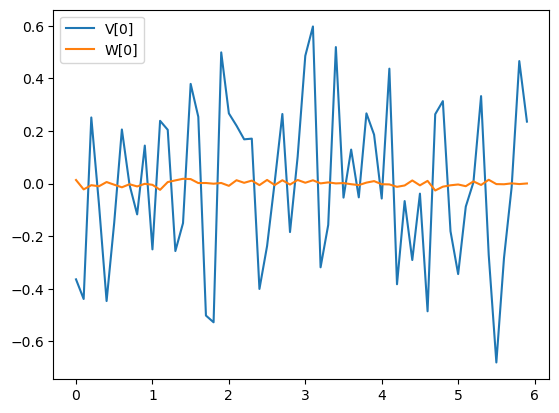

In [21]:
# Create a new list of time points
timepts = np.arange(0, Tf, Ts)

# Create representative process disturbance and sensor noise vectors
# np.random.seed(117)           # avoid figures changing from run to run
V = ct.white_noise(timepts, Qv)
# V = np.clip(V0, -0.1, 0.1)    # Hold for later
W = ct.white_noise(timepts, Qw, dt=Ts)
# plt.plot(timepts, V0[0], 'b--', label="V[0]")
plt.plot(timepts, V[0], label="V[0]")
plt.plot(timepts, W[0], label="W[0]")
plt.legend();

In [22]:
# Generate a new trajectory over the longer time vector
uvec = [xd, ud, V, W*0]
lqr_resp = ct.input_output_response(lqr_clsys, timepts, uvec, x0)
U = lqr_resp.outputs[6:8]                    # controller input signals
Y = lqr_resp.outputs[0:3] + W                # noisy output signals

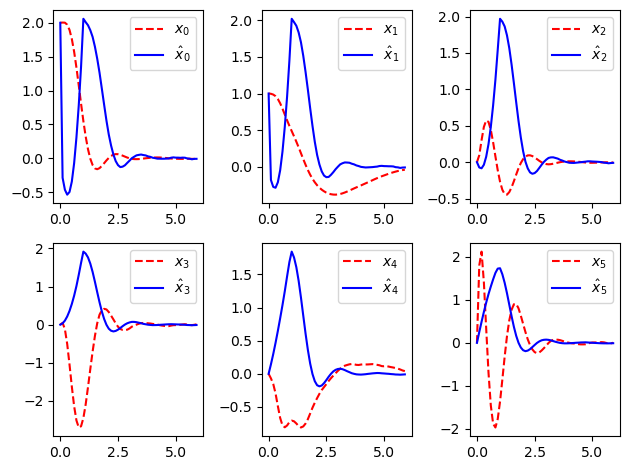

In [23]:
mhe_timepts = timepts[0:10]
oep = opt.OptimalEstimationProblem(
        dsys, mhe_timepts, traj_cost, terminal_cost=init_cost,
        disturbance_indices=slice(2, 4))
mhe = oep.create_mhe_iosystem()
    
mhe_resp = ct.input_output_response(
    mhe, timepts, [Y, U], X0=x0, 
    params={'verbose': True}
)
plot_state_comparison(timepts, mhe_resp.states, lqr_resp.states)

In [24]:
# Resimulate starting at the origin and moving to the "initial" condition
uvec = [x0, ue, V, W*0]
lqr_resp = ct.input_output_response(lqr_clsys, timepts, uvec, xe)
U = lqr_resp.outputs[6:8]                    # controller input signals
Y = lqr_resp.outputs[0:3] + W                # noisy output signals

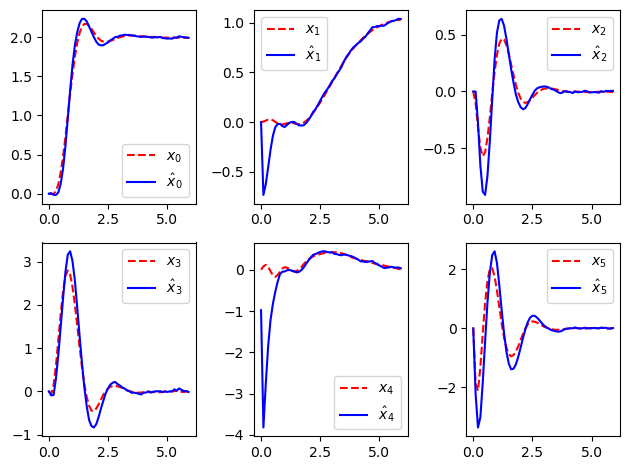

In [25]:
mhe_timepts = timepts[0:8]
oep = opt.OptimalEstimationProblem(
        dsys, mhe_timepts, traj_cost, terminal_cost=init_cost,
        disturbance_indices=slice(2, 4))
mhe = oep.create_mhe_iosystem()
    
mhe_resp = ct.input_output_response(
    mhe, timepts, [Y, U],
    params={'verbose': True}
)
plot_state_comparison(timepts, mhe_resp.outputs, lqr_resp.states)